# Combined 2D Models & Error-Time Graph

In [16]:
# imports
import numpy as np
import random
import matplotlib.pyplot as plt

## Initializations & Functions

In [17]:
# initialize parameters
Lx, Ly = 2, 3
Nx, Ny = 8, 12
dx, dy = Lx / Nx, Ly / Ny
N = 96
D = 5.13e-6

In [18]:
# discrete functions
# random neighbor selection function (discrete)
def select_random_neighbor(x, y):
    neighbors = [
        ((x - 1) % Nx, y),
        ((x + 1) % Nx, y),
        (x, (y - 1) % Ny),
        (x, (y + 1) % Ny)
    ]
    return random.choice(neighbors)

# diffusion function (discrete)
def diffuse(grid, ion_positions, pmove):
    new_grid = np.copy(grid)
    new_ion_positions = np.copy(ion_positions)

    for i in range(N):
        x, y = ion_positions[i]
        if grid[x, y] != 0:
            nbr_x, nbr_y = select_random_neighbor(x, y)
            if grid[nbr_x, nbr_y] == 0:
                if pmove > random.random():
                    new_grid[nbr_x, nbr_y] += 1
                    new_grid[x, y] -= 1
                    new_ion_positions[i] = (nbr_x, nbr_y)

    return new_grid, new_ion_positions

In [19]:
# continuous function
# Laplacian function to turn into matrix
def laplacian(dx, dy, n, m):
    k=n*m
    q= k-m
    s = (n * m, n * m)
    l = np.zeros(s)
    for i in range(q):
        l[i][m +i] = 1 / (2*pow(dx,2))
        l[i+m][i] = 1 / (2*pow(dx,2))
        #l[i-1][m +(i-1)] = 1 / (2*pow(dx,2))
        #l[(i-1)+m][(i-1)] = 1 / (2*pow(dx,2))
    for i in range(k):
      if i % m != 0:
        #l[i+1,i] = 1 / (2*pow(dy,2))
        #l[i,i+1] = 1 / (2*pow(dy,2))
        l[i,i-1] = 1 / (2*pow(dy,2))
        l[i-1,i] = 1 / (2*pow(dy,2))
    for i in range(k):
      l[i][i] = -np.sum(l[i, :])
    return l

## Everything Function
- runs models
- returns x, y values of list (x: time in ms, y: MSE for each time step of models)

In [20]:
def everything(dt):

  max_time_steps = int(750000 / dt) # half time steps for faster run: 750000
  pmove = (D * 3 * dt) / dx ** 2  # movement probability

  # np.random.seed(123)
  # initialize grid and ion positions (discrete)
  grid = np.zeros((Nx, Ny), dtype=int)

  ion_x = np.mod(np.random.normal(0.3 * Lx, 0.5, N), Lx)
  ion_y = np.mod(np.random.normal(0.3 * Ly, 0.5, N), Ly)
  ion_i = np.ceil(ion_x / dx).astype(int)
  ion_j = np.ceil(ion_y / dy).astype(int)
  for i in range(N):
      grid[ion_i[i] % Nx, ion_j[i] % Ny] += 1


  # define variables for creation of Laplacian matrix
  n, m = Nx, Ny
  k = n * m
  I = np.identity(k)
  l = laplacian(dx, dy, n, m)
  A = I - ((dt * D) / 2) * l
  B = I + ((dt * D) / 2) * l

  phi = np.array(grid) # initialize phi as the same as grid
  comptransphi = phi.T # complex conjugate transpose
  vecphi = np.reshape(comptransphi, (k,1), order = "F") # reshape


  # compare models at time step 0 (error = 0)
  ion_positions = np.column_stack((ion_i % Nx, ion_j % Ny))
  discrete_model = grid.copy()
  cont_model = grid.copy()
#   error = (discrete_model - cont_model) ** 2
#   MSE = np.sum(error) / k

  x_vals = [0] # same model initializations so error = 0
  y_vals = [0]


  # simulation loop to advance both models
  for t in range(1, max_time_steps):
      # print(f"Debugging: simulation loop {t} out of {max_time_steps}")

      # advance continuous model
      vecphi = np.reshape(cont_model.T, (k, 1), order = "F")
      newphi = np.linalg.solve(A, np.matmul(B, vecphi))
      vecphi = newphi
      cont_model = np.reshape(vecphi, (m, n)).T # reshape continous will be nXm

      # advance discreete model
      discrete_model, ion_positions = diffuse(discrete_model, ion_positions, pmove)

      # calculate MSE
      error = (discrete_model - cont_model) ** 2
      MSE = np.sum(error) / k

      # append values for ERROR GRAPH!!
      x_vals.append(t)
      y_vals.append(MSE)

  x_list = [i * dt for i in x_vals] # convert from time step to ms

  return x_list, y_vals

I manually searched the best time steps (dt) to minimize MSE the quickest. Using manual hyperparameter tuning was fine since it used my intuition, but I could use something more systematic like grid search to explore different values of dt.

In [21]:
x_lists = {}
y_vals = {}

for dt in (900, 1000, 1100, 2000): # these time steps seems to be the best
  # print(f"Running for dt: {dt}")
  x_lists[dt], y_vals[dt] = everything(dt) # run everything function to populate x, y

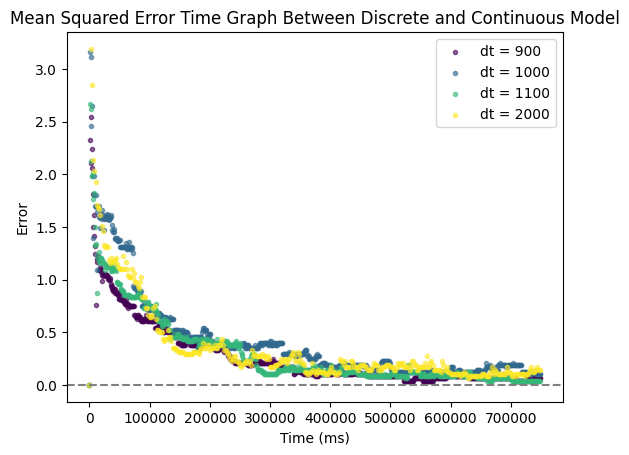

In [22]:
plt.figure()

colors = plt.cm.viridis(np.linspace(0, 1, len(x_lists))) # viridis color scheme

# plot each pair of lists from x_lists and y_vals
for i,index in enumerate(x_lists):
    plt.scatter(x_lists[index], y_vals[index], label=f'dt = {index}', marker='.', color=colors[i], alpha=0.6)

plt.axhline(y = (N * pow((1-N/(Nx*Ny)),2) + pow(0 - N/(Nx*Ny),2)*((Nx*Ny-N)))/(Nx*Ny), color = 'gray', linestyle = 'dashed') # min line

plt.xlabel('Time (ms)')
plt.ylabel('Error')
plt.title('Mean Squared Error Time Graph Between Discrete and Continuous Model')
plt.legend()

plt.show()